In [3]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

En el siguiente notebook se da una explicación de como se calcula el índice de presión hospitalaria. 

Para cada hospital tomamos las regiones de los cuales son "*responsables*", la división de estas regiones se determina por una división administrativa que se encuentra fija.  Esta división implica que si tenemos un enfermo dentro de una región asignada al hospital $H_0$, el enfermo será atendido en el hospital $H_0$. La intención del índice  es tener una aproximación del estrés generado por una enfermedad  sobre los recursos propios del hospital.

La información con la que contamos y sobre la cual se desarrolla el índice es la siguiente. 

La población total $N$ asignada al hospital, si el hospital atiende a $l$ regiones entonces $N= N_0, N_1, \dots N_l $. Se $S$ la población susceptible a la enfermedad la cual es un porcentaje la población total, este porcentaje puede variar dependiendo de la enfermedad y los rangos de edad de la población, para el siguiente ejercicio vamos a suponer que la enfermedad es un porcentaje fijo de la población total $ S = \alpha_s N$ donde $\alpha \in ( 0, 1]$. 


A partir de un modelos modelo *SIR* vamos apróximar el número de camas que se necesitarán    


In [5]:
N = 100000
alpha_s = .98
S_i = alpha_s*N

A partir de un modelo *SIR* (suceptible, infected, recover) podemos hacer un cálculo aproximado de el número de individuos que se encuentren enfermos (infectados) en cada  día a partir de la primera infección enfermedad. Para el cálculo del modelo *SIR* es necesario saber la taza de contagio, la taza de recuperación. En este ejercicio utilicemos los datos mundiales del covid-19 para la aproximación de la taza de contagio en el caso de México.


Para la taza de recuperación tomemos el tiempo de recuperación de la enfermedad o el tiempo que es infeccioso el infectado, para este caso tomemos un periode de recuperación de 42 días. dando una taza de recuperación de $\frac{1}{42}$ 

## Aplicación del modelo SIR


Apliquemos el modelo primero para el caso de *exponential grow* 

In [7]:
START_DATE = {
  'Japan': '1/22/20',
  'Italy': '1/31/20',
  'Republic of Korea': '1/22/20',
  'Iran (Islamic Republic of)': '2/19/20'
}

class Learner(object):
    def __init__(self, country, loss):
        self.country = country
        self.loss = loss

    def load_confirmed(self, country):
      """
      Load confirmed cases downloaded from HDX
      """
      df = pd.read_csv('data/time_series_19-covid-Confirmed.csv')
      country_df = df[df['Country/Region'] == country]
      return country_df.iloc[0].loc[START_DATE[country]:]

    def extend_index(self, index, new_size):
        values = index.values
        current = datetime.strptime(index[-1], '%m/%d/%y')
        while len(values) < new_size:
            current = current + timedelta(days=1)
            values = np.append(values, datetime.strftime(current, '%m/%d/%y'))
        return values

    def predict(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 150
        new_index = self.extend_index(data.index, predict_range)
        size = len(new_index)
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return new_index, extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        data = self.load_confirmed(self.country)
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = self.predict(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        }, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.country)
        df.plot(ax=ax)
        fig.savefig(f"{self.country}.png")

In [8]:
def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))


In [9]:
def loss(point, data, recovered):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    # Put more emphasis on recovered people
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [85]:
def get_data(country_s= 'Mexico'):

    #### Get the data 
    ff  = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master"
    ff  = ff + "/csse_covid_19_data/csse_covid_19_time_series/"
    ff  = ff + "time_series_covid19_confirmed_global.csv"
    #df_dat = pd.read_csv(ff, header=TRUE ,sep=",")
    


    #remove_province('data/time_series_19-covid-Confirmed.csv', 'data/time_series_19-covid-Confirmed-country.csv')
    #remove_province('data/time_series_19-covid-Recovered.csv', 'data/time_series_19-covid-Recovered-country.csv')
    #remove_province('data/time_series_19-covid-Deaths.csv', 'data/time_series_19-covid-Deaths-country.csv')
    df_dat = pd.read_csv(ff,header=0, sep = ",")
    df_dat.drop(columns=['Province/State'], inplace= True)
    country = df_dat[df_dat['Country/Region']==country_s]
     
    
    col_ra=[]
    
    for col in country.columns:
        #print(col)
        if country[col].values[0] != 0:
            col_ra.append(col)
    col_ra.remove('Country/Region')
    col_ra.remove( 'Lat')
    col_ra.remove('Long')
    
    case = country[col_ra].values.tolist()[0]
    new_cases= [x[0]-x[1] for x in zip(case[1:]  ,case[:len(case)-1])]
    return (country, case, new_cases)

In [88]:
contry , cases, new_cases  =get_data()

In [98]:
def loss(beta_i, gamma_i, data, recovered, s_0, i_0, r_0):
    size = len(data)
    beta= beta_i
    gamma = gamma_i
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [s_0,i_0,r_0], t_eval=np.arange(0, size, 1), vectorized=True)
    l1 = np.sqrt(np.mean((solution.y[1] - data)**2))
    l2 = np.sqrt(np.mean((solution.y[2] - recovered)**2))
    alpha = 0.1
    return alpha * l1 + (1 - alpha) * l2

In [100]:

def train(s_0=100000, i_0=1, r_0=0):
    #recovered = load_recovered(country)
    #death = self.load_dead(self.country)
    data = (self.load_confirmed(self.country) - recovered - death)
    optimal = minimize(loss, [0.001, 0.001], args=(data, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.6), (0.00000001, 0.6)])
    print(optimal)
    beta, gamma = optimal.x
    new_index, extended_actual, extended_recovered, extended_death, prediction = self.predict(beta, gamma, data, recovered, death, self.country, self.s_0, self.i_0, self.r_0)
    df = pd.DataFrame({'Infected data': extended_actual, 'Recovered data': extended_recovered, 'Death data': extended_death, 'Susceptible': prediction.y[0], 'Infected': prediction.y[1], 'Recovered': prediction.y[2]}, index=new_index)
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title(self.country)
    df.plot(ax=ax)
    print(f"country={self.country}, beta={beta:.8f}, gamma={gamma:.8f}, r_0:{(beta/gamma):.8f}")
    fig.savefig(f"{self.country}.png")

In [94]:
s_0 = 5000
i_0 =  1
r_0 = 0

In [99]:
optimal = minimize(loss, [0.001, 0.001], args=(cases, recovered, s_0, i_0, r_0), method='L-BFGS-B', bounds=[(0.00000001, 0.6), (0.00000001, 0.6)])

NameError: name 'recovered' is not defined

La siguiente función emula el comportamiento de la pandemia a un nivel local utilizando aproximaciones obtenidas a nivel pais (Mexico) de 

In [117]:

### Con estos valores vamos a resolver nuestro caso 
###### beta=0.00000085, gamma=0.00000001, r_0:85.16670412

def SIR_compute(S_0= 100000, I_0= 1, R_0=0 , beta=0.00000085 ,gamma=0.00000001, time=100):
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    size = time
    solution = solve_ivp(SIR, [0, size] , [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return solution

Utilizando la función podemos hacer una aproximación del comportamiento esperado a nivel local en un intervalo de tiempo de 250 días

In [255]:
comu=SIR_compute(time = 250)

grafiquemos los resultados obtenidos

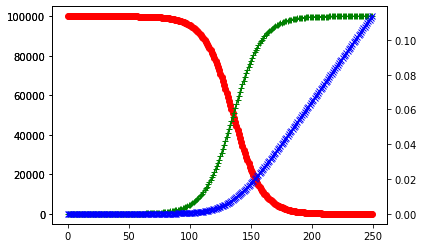

In [256]:
fig , ax=plt.subplots()
#ax=fig.add_subplot(111,label='Suceptibles')
#ax2=fig.add_subplot(111,label='Infectados')
#ax3=fig.add_subplot(111,label='Recuperados')
ax.plot(comu['t'], comu['y'][0],color="red", marker="o")
ax2=ax.twinx()
ax2.plot(comu['t'], comu['y'][1], color="green", marker="+")
ax3=ax2.twinx()
ax3.plot(comu['t'], comu['y'][2], color="blue", marker="x")
plt.show()

Como se observa el comportamiento de infectados (verde) y los suceptibles es el esperado, pero en el casos de los individuos recuperados se observa que no es de la forma esperada. Esto se debe a que los valores para ajustar dichas curvas corresponden a poblaciones distintas. Si se gráfica se observa el error de esta forma de modelado. 

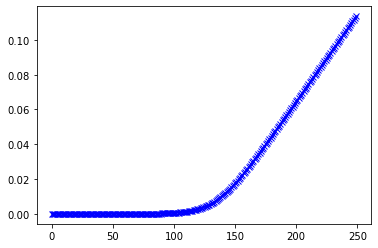

In [257]:
plt.plot(comu['t'], comu['y'][2], color="blue", marker="x")
plt.show()

Los recuperados esta mal aproximados es decir que la taza que tomamos para su recuperación es la que esta mal. Como los valores de el número de infectados son similares vamos a dejarl la aproximación de infectados así. Vamos a tomar a los infectados y esperar a que se recuperen (recuperados y muertos), estos serán los que tomamos como recuperados el factor de recuperación lo tomamos como $42$ días. 


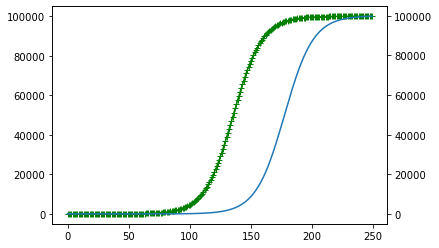

In [313]:

fig , ax=plt.subplots()
#ax=fig.add_subplot(111,label='Suceptibles')
#ax2=fig.add_subplot(111,label='Infectados')
#ax3=fig.add_subplot(111,label='Recuperados')
ax.plot(comu['t'], comu['y'][1], color="green", marker="+")
ax2=ax.twinx()
rep= np.repeat(0, 43) 
rec_de = np.concatenate((rep, comu['y'][1][1:len(comu['y'][1])-42]))
ax2.plot(comu['t'], rec_de)
plt.show()


En el siguiente escenario el hospital tiene $200$ camas, donde el $16\%$ de los infectados necesitaran camas. Obtenemos un aproximado de las camas necesarias en cada tiempo. 

In [290]:
camas_total=200
#gamma=0.00000001
camas_nec_nue = 0.16*(comu['y'][1][1:]-comu['y'][1][:len(comu['y'][1])-1] )
camas_de_rec =  0.16*( comu['y'][1][1:len(comu['y'][1])-42]- comu['y'][1][:len(comu['y'][1])-42-1] )

Las camas que se liberan a partir de los recuperados en cada tiempo.

In [291]:
rep=np.repeat(0,42)
camas_de_rec=np.concatenate(( rep, camas_de_rec))
len(camas_de_rec)

249

249

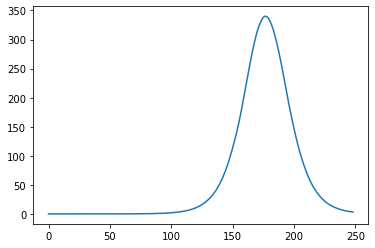

In [292]:
plt.plot(camas_de_rec)
len(camas_de_rec)

Las camas necesarias sin contar las liberadas es la suma acumulada en cada instante. 

In [331]:
camas_nec= np.cumsum(camas_nec_nue)

La demanda de camas queda de la siguiente forma

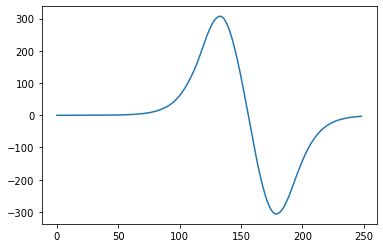

In [334]:
plt.plot(( camas_nec_nue - camas_de_rec ))

In [336]:
camas_dem = camas_nec_nue - camas_de_rec

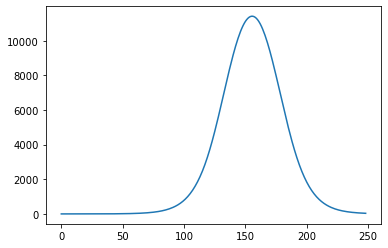

In [337]:
plt.plot(np.cumsum(camas_dem ) )

El índice nos da que tan estresada se encuentra la infrestructura hospitalaría en cada tiempo. Entre más cercano a $0$ la infrestructura sera menor

<BarContainer object of 249 artists>

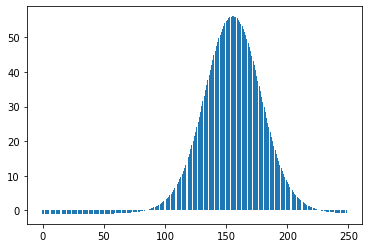

In [338]:
index_hos= (np.cumsum(camas_dem )- camas_total)/200
plt.bar(comu['t'][:len(comu['t'])-1] ,index_hos)

In [346]:
def indice_hosp(poblaciaon_hos=100000, 
                infectados_actuales=1,
                recuperados=0,
                beta=0.00000085,
                gamma=0.00000001, 
                time=200,
                camas_total=200,
                por_hosp=0.16,
                rec_time=42
               ):
    ### Calculamos la solución del sistema para este caso 
    
    comu=SIR_compute(S_0= poblaciaon_hos, I_0= infectados_actuales, R_0=recuperados , beta=beta ,gamma=gamma, time=time)
    camas_nec_nue = por_hosp*(comu['y'][1][1:]-comu['y'][1][:len(comu['y'][1])-1] )
    camas_de_rec =  por_hosp*( comu['y'][1][1:len(comu['y'][1])-rec_time]- comu['y'][1][:len(comu['y'][1])-rec_time-1] )
    rep=np.repeat(0,rec_time)
    camas_de_rec=np.concatenate(( rep, camas_de_rec))
    camas_nec= np.cumsum(camas_nec_nue)
    camas_dem = camas_nec_nue - camas_de_rec
    index_hos= (np.cumsum(camas_dem )- camas_total)/camas_total
    return index_hos , comu

<BarContainer object of 199 artists>

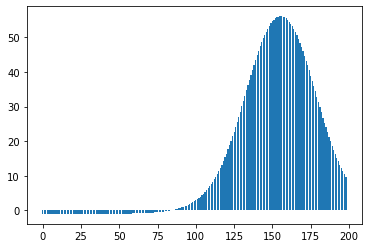

In [351]:
ind_ho , comu = indice_hosp()
len(ind_ho)
plt.bar(comu['t'][:len(comu['t'])-1],height=ind_ho)